In [1]:
# load librairies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from os.path import join
import seaborn as sns
import scipy
import json


from functions import utils

In [2]:
included_subjects = [
    'preop001 mSST', 

    'C002 mSST', 'C003 mSST', 'C004 mSST', 'C006 mSST', 
    
    'sub006 DBS ON mSST', 'sub006 DBS OFF mSST', 
    'sub007 DBS OFF mSST', 
    'sub008 DBS ON mSST', 'sub008 DBS OFF mSST', 
    'sub009 DBS ON mSST', 'sub009 DBS OFF mSST', 
    'sub011 DBS OFF mSST', 'sub011 DBS ON mSST', 
    'sub012 DBS ON mSST', 
    'sub013 DBS OFF mSST', 
    'sub014 DBS ON mSST', 
    'sub015 DBS OFF mSST', 'sub015 DBS ON mSST', 
    'sub017 DBS ON mSST',  'sub017 DBS OFF mSST', 
    'sub019 DBS ON mSST', 'sub019 DBS OFF mSST', 
    'sub020 DBS ON mSST', 
    'sub021 DBS OFF mSST', 'sub021 DBS ON mSST', 
    'sub022 DBS ON mSST', 
    'sub023 DBS OFF mSST', 'sub023 DBS ON mSST',
    'sub024 DBS ON mSST'
    ]

In [3]:
onedrive_path = utils._get_onedrive_path()
working_path = os.path.dirname(os.getcwd())
results_path = join(working_path, "results")
behav_results_saving_path = join(results_path, "behav_results")
if not os.path.isdir(behav_results_saving_path):
    os.makedirs(behav_results_saving_path)

In [4]:
# load data by looping through the subjects
data = {}
for subject in included_subjects:
    if subject.startswith('sub'):
        subject_ID, na, condition, task = subject.split(' ')
        sub_onedrive_path = join(onedrive_path, subject_ID)
        sub_onedrive_path_raw = join(sub_onedrive_path, 'raw_data')
        sub_onedrive_path_behav = join(sub_onedrive_path_raw, 'BEHAVIOR')
        sub_onedrive_path_condition = join(sub_onedrive_path_behav, (na + ' ' + condition))
        sub_onedrive_path_task = join(sub_onedrive_path_condition, task)
        behav_filename = [f for f in os.listdir(sub_onedrive_path_task) if f.endswith('.csv')]
        filepath = join(sub_onedrive_path_task, behav_filename[0])
        df = pd.read_csv(filepath)
        
    elif subject.startswith('C'):
        subject_ID, task = subject.split(' ')
        sub_onedrive_path = join(onedrive_path, subject_ID)
        sub_onedrive_path_raw = join(sub_onedrive_path, 'raw_data')
        sub_onedrive_path_behav = join(sub_onedrive_path_raw, 'BEHAVIOR')
        sub_onedrive_path_task = join(sub_onedrive_path_behav, task)
        behav_filename = [f for f in os.listdir(sub_onedrive_path_task) if f.endswith('.csv')]
        filepath = join(sub_onedrive_path_task, behav_filename[0])
        df = pd.read_csv(filepath)
    
    elif subject.startswith('preop'):
        subject_ID, task = subject.split(' ')
        sub_onedrive_path = join(onedrive_path, subject_ID)
        sub_onedrive_path_raw = join(sub_onedrive_path, 'raw_data')
        sub_onedrive_path_behav = join(sub_onedrive_path_raw, 'BEHAVIOR')
        sub_onedrive_path_behav_preop = join(sub_onedrive_path_behav, 'PRE OP')
        sub_onedrive_path_task = join(sub_onedrive_path_behav_preop, task)
        behav_filename = [f for f in os.listdir(sub_onedrive_path_task) if f.endswith('.csv')]
        filepath = join(sub_onedrive_path_task, behav_filename[0])
        df = pd.read_csv(filepath)        

    data[subject] = df

In [5]:
color_dict = {
    'dbs_off': '#20a39e', 
    'dbs_on': '#ef5b5b', 
    'control': '#ffba49', 
    'preop': '#8E7DBE'
    }


In [20]:
staircase_df = pd.DataFrame(columns=['subject', 'stop_signal_time', 'key_resp_experiment.corr', 'trial_number', 'correct'])
main_summary_df = pd.DataFrame(columns = ['subject', 'number of wrong SSD adjustment', 'total number of stop trials', 'percentage incorrect'])

for sub in data.keys():
    summary_df = pd.DataFrame()
    stop_trials = data[sub][data[sub]['trial_type'] == 'stop_trial']
    columns = ['stop_signal_time', 'key_resp_experiment.corr']
    stop_trials = stop_trials[columns].dropna()

    stop_trials['subject'] = sub
    stop_trials['trial_number'] = np.arange(1, len(stop_trials) + 1)

    # Compute shifted stop_signal_time for next trial
    next_ssd = stop_trials['stop_signal_time'].shift(-1)

    # Default all to True first
    stop_trials['correct'] = True

    # Apply rules only to trials except the last one
    mask = stop_trials.index[:-1]

    # If corr == 1, next stop_signal_time should be higher
    stop_trials.loc[mask, 'correct'] = np.where(
        stop_trials.loc[mask, 'key_resp_experiment.corr'] == 1,
        next_ssd[mask] > stop_trials.loc[mask, 'stop_signal_time'],
        True  # corr == 0 → next trial always correct
    )
    # count and print the number of incorrect trials
    num_incorrect = np.sum(stop_trials['correct'] == False)
    print(f"Subject: {sub}, Incorrect trials: {num_incorrect} over {len(stop_trials)} trials")

    # create a mini summary df and append to main_summary_df
    row = {
        'subject': sub, 'number of wrong SSD adjustment': num_incorrect, 
        'total number of stop trials': len(stop_trials), 
        'percentage incorrect': num_incorrect*100/len(stop_trials)
        }
    main_summary_df = main_summary_df.append(row, ignore_index=True)

    # Append to master df
    staircase_df = pd.concat([staircase_df, stop_trials], ignore_index=True)

# save the main summary df
main_summary_df.to_excel(join(results_path, "staircase values for all subjects.xlsx"), index=False)


Subject: preop001 mSST, Incorrect trials: 2 over 60 trials
Subject: C002 mSST, Incorrect trials: 6 over 80 trials
Subject: C003 mSST, Incorrect trials: 5 over 80 trials
Subject: C004 mSST, Incorrect trials: 1 over 60 trials
Subject: C006 mSST, Incorrect trials: 6 over 80 trials
Subject: sub006 DBS ON mSST, Incorrect trials: 4 over 80 trials
Subject: sub006 DBS OFF mSST, Incorrect trials: 1 over 60 trials
Subject: sub007 DBS OFF mSST, Incorrect trials: 3 over 60 trials
Subject: sub008 DBS ON mSST, Incorrect trials: 15 over 80 trials
Subject: sub008 DBS OFF mSST, Incorrect trials: 18 over 80 trials
Subject: sub009 DBS ON mSST, Incorrect trials: 7 over 80 trials
Subject: sub009 DBS OFF mSST, Incorrect trials: 15 over 80 trials
Subject: sub011 DBS OFF mSST, Incorrect trials: 4 over 80 trials
Subject: sub011 DBS ON mSST, Incorrect trials: 2 over 60 trials
Subject: sub012 DBS ON mSST, Incorrect trials: 6 over 60 trials
Subject: sub013 DBS OFF mSST, Incorrect trials: 3 over 60 trials
Subject:

C:\Users\Juliette\AppData\Local\Temp\ipykernel_19380\3372217212.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_summary_df = main_summary_df.append(row, ignore_index=True)
C:\Users\Juliette\AppData\Local\Temp\ipykernel_19380\3372217212.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  main_summary_df = main_summary_df.append(row, ignore_index=True)
C:\Users\Juliette\AppData\Local\Temp\ipykernel_19380\3372217212.py:41: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  staircase_df = pd.concat([staircase_df, stop_trials], ignore_index=True)
C:\Users\Juliette\AppData\Local\Temp\ipykernel_19380\3372217212.py:38: FutureWarning: The frame.append method is deprecated and will be rem

C:\Users\Juliette\AppData\Local\Temp\ipykernel_19380\3012341025.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 6))


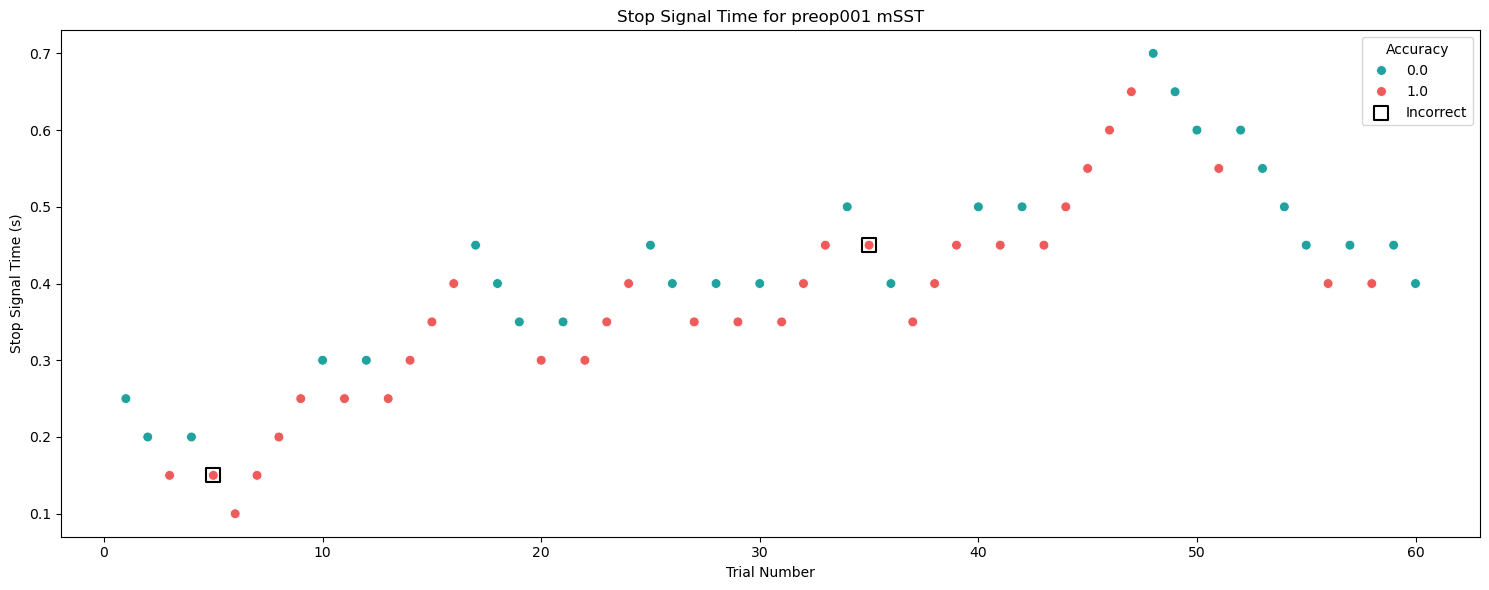

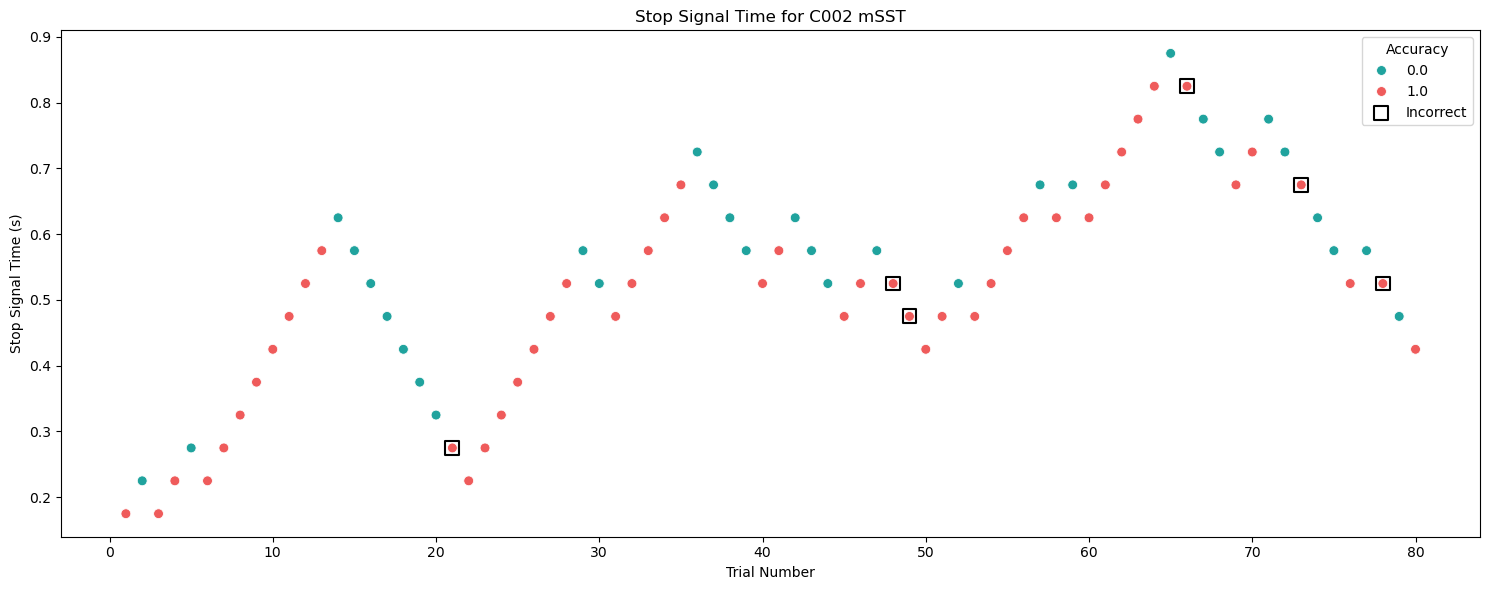

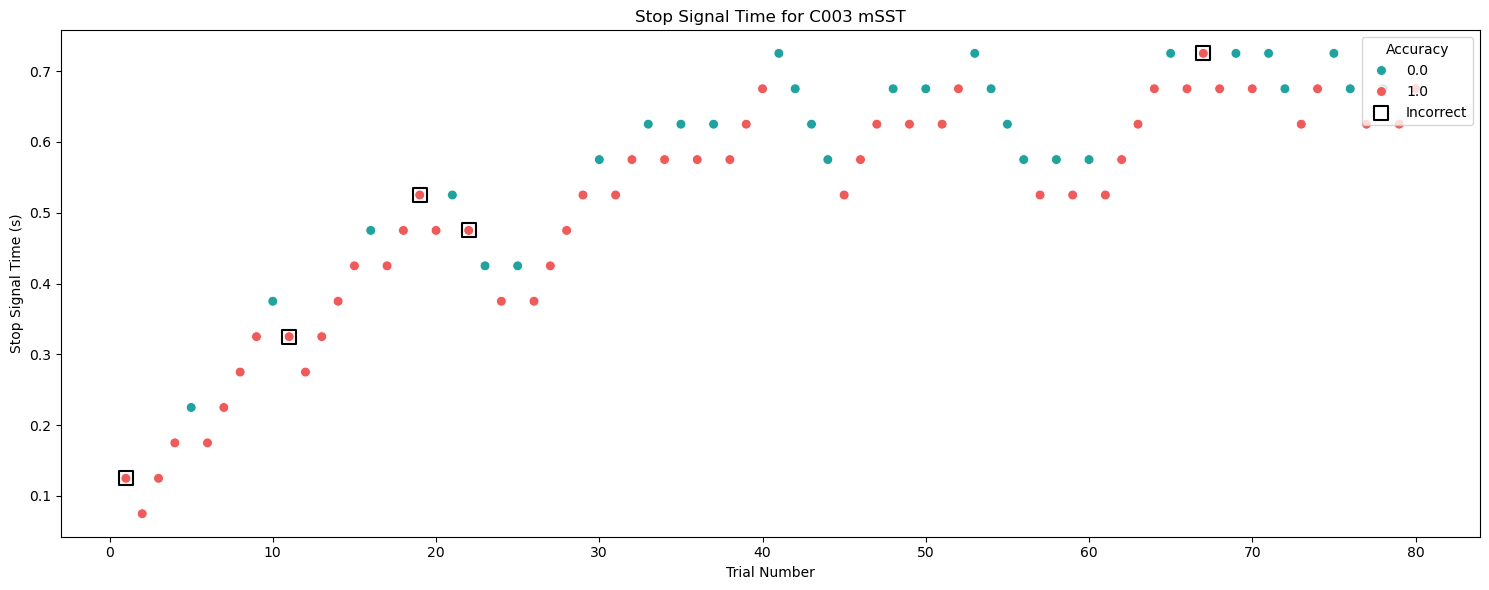

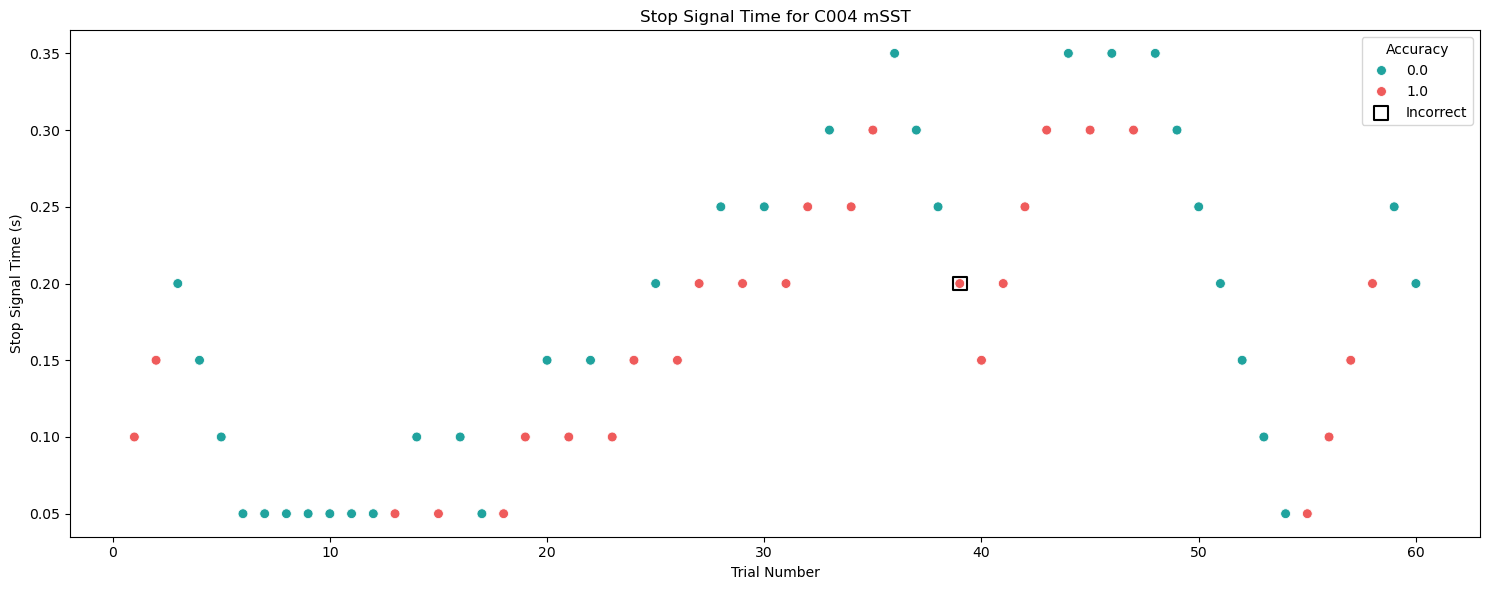

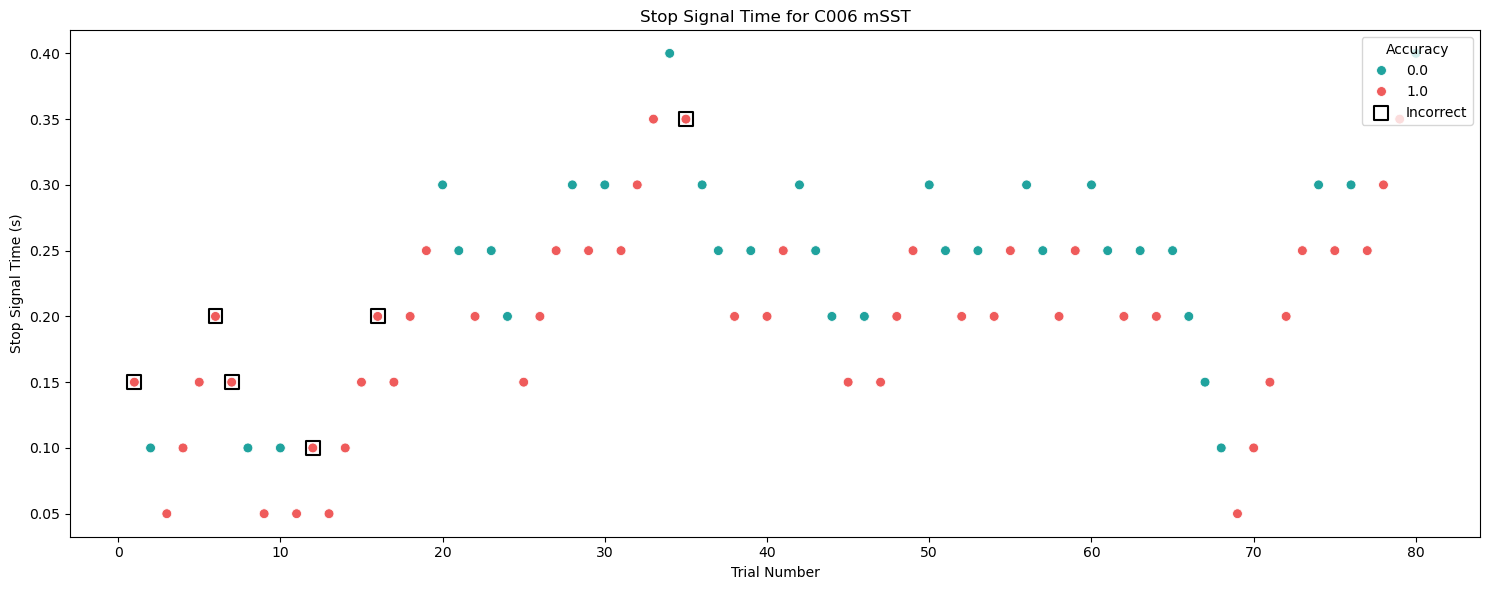

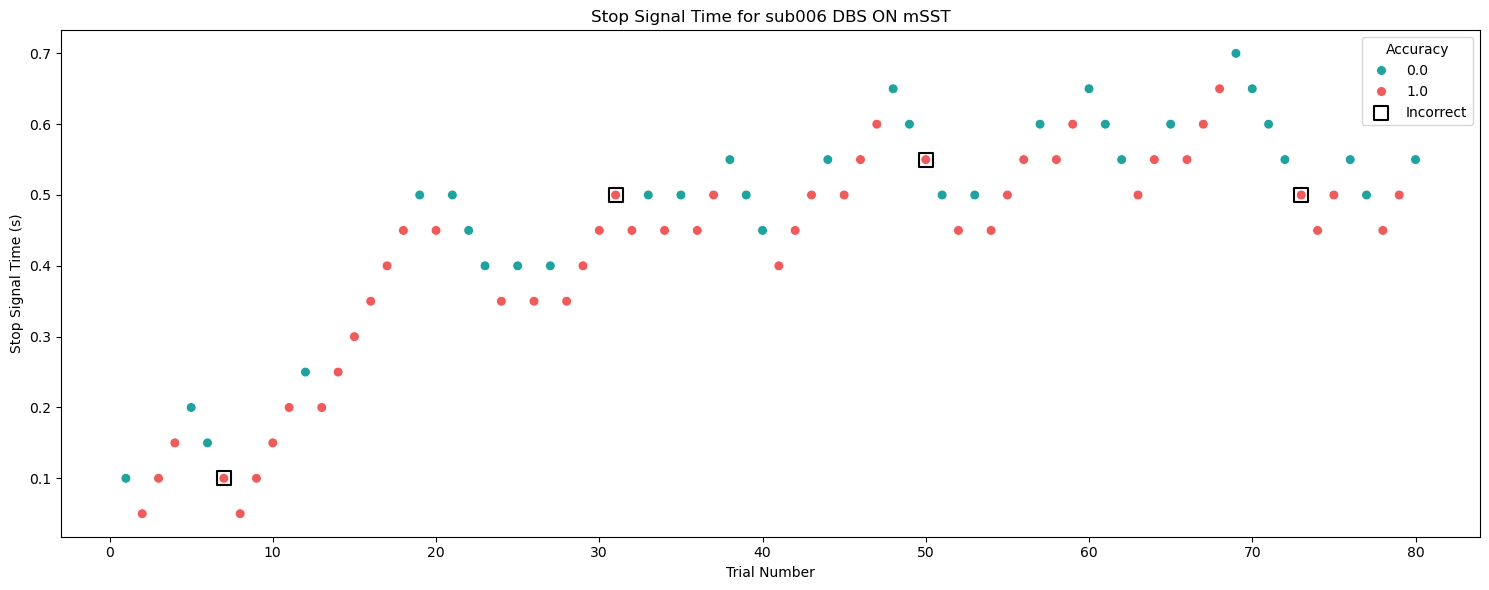

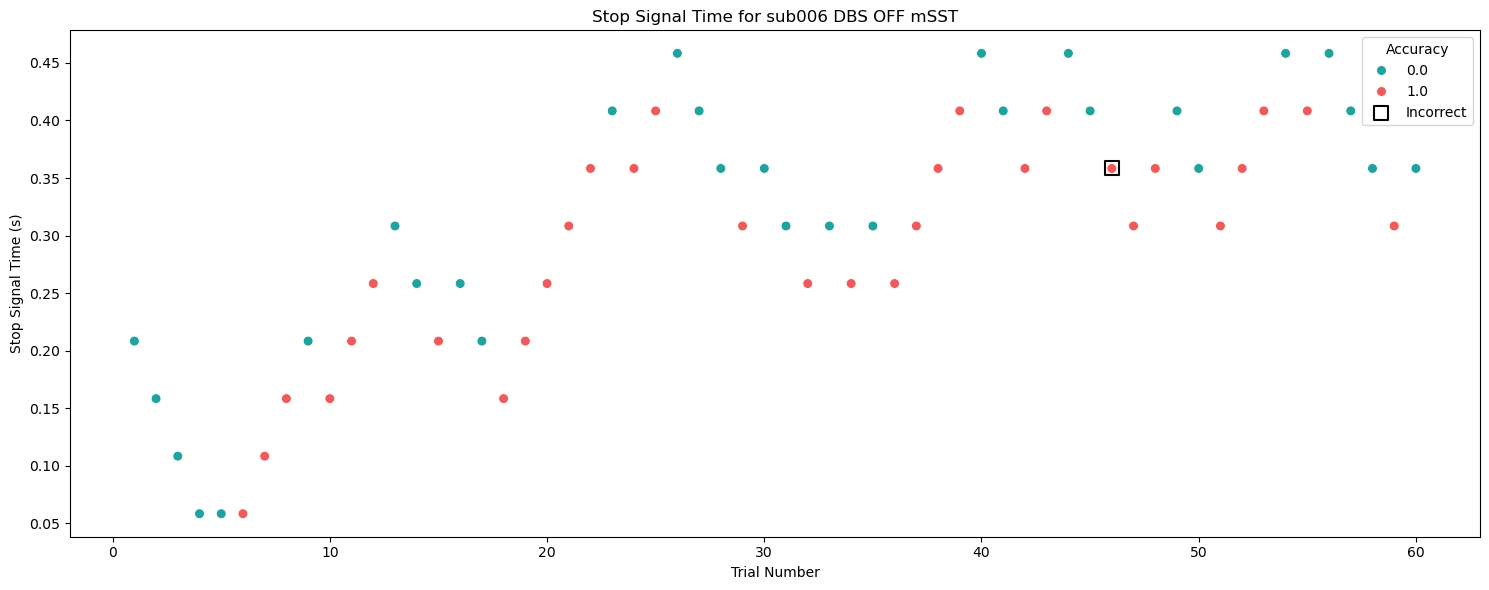

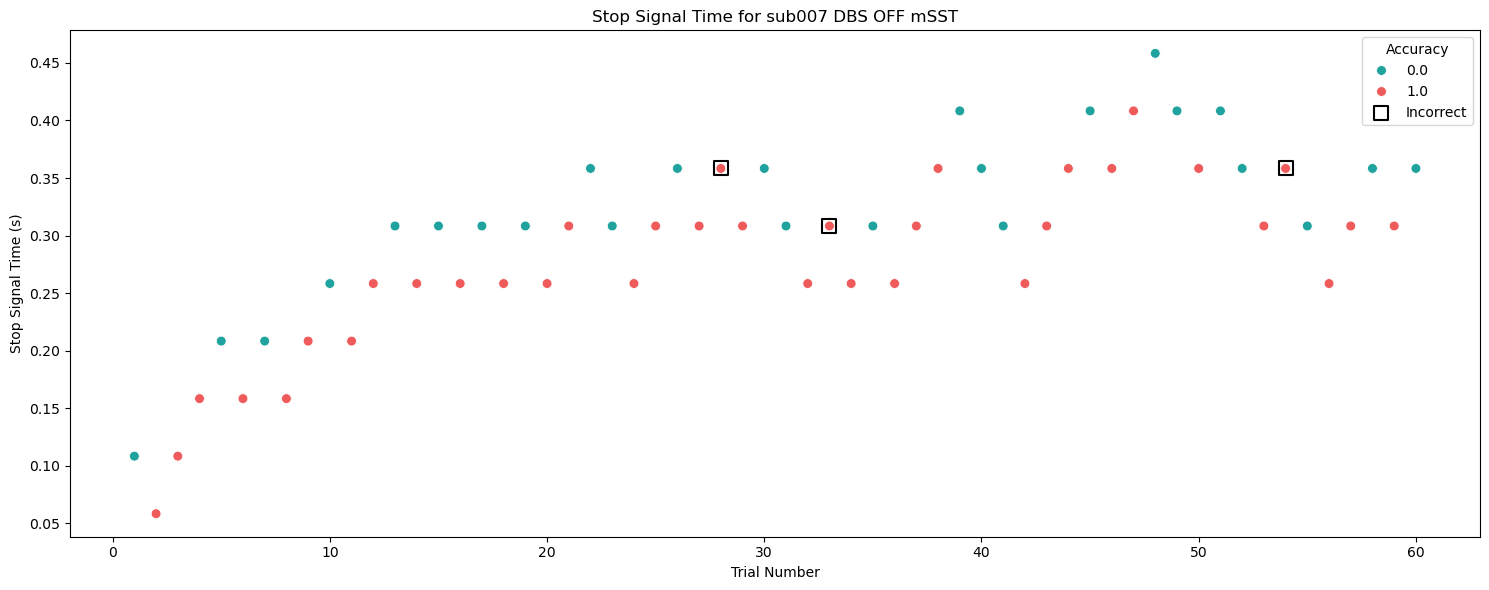

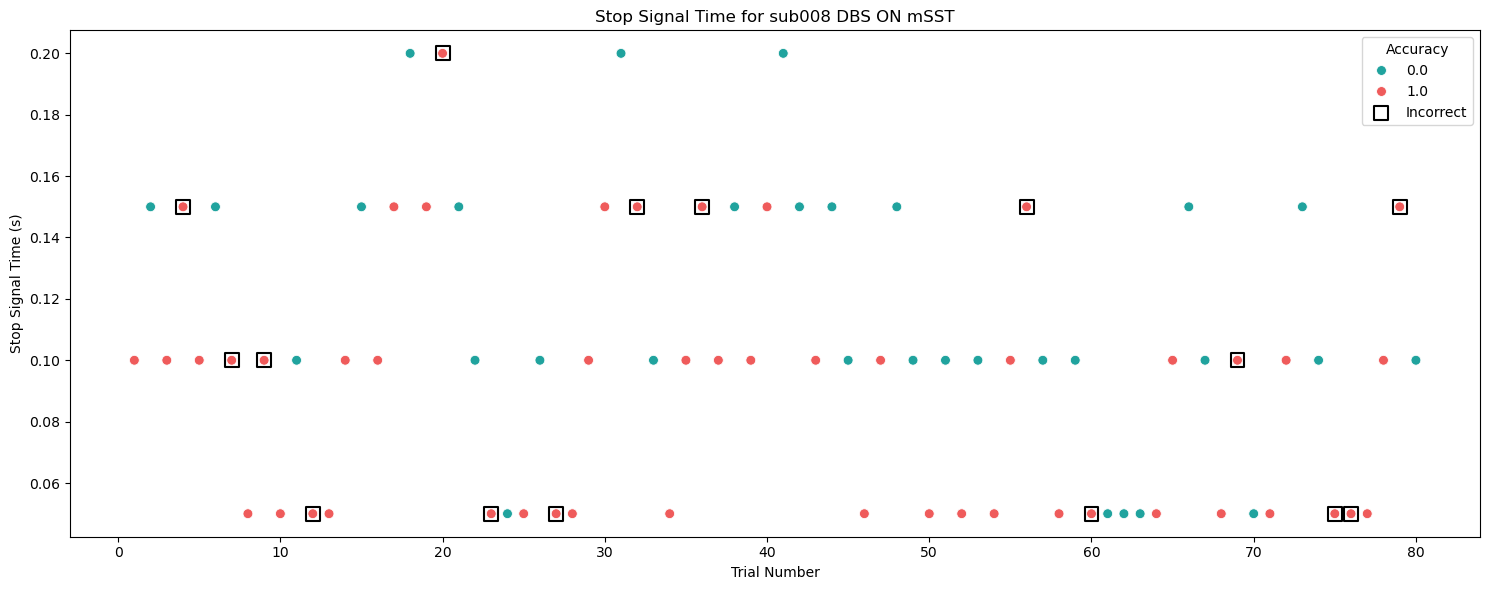

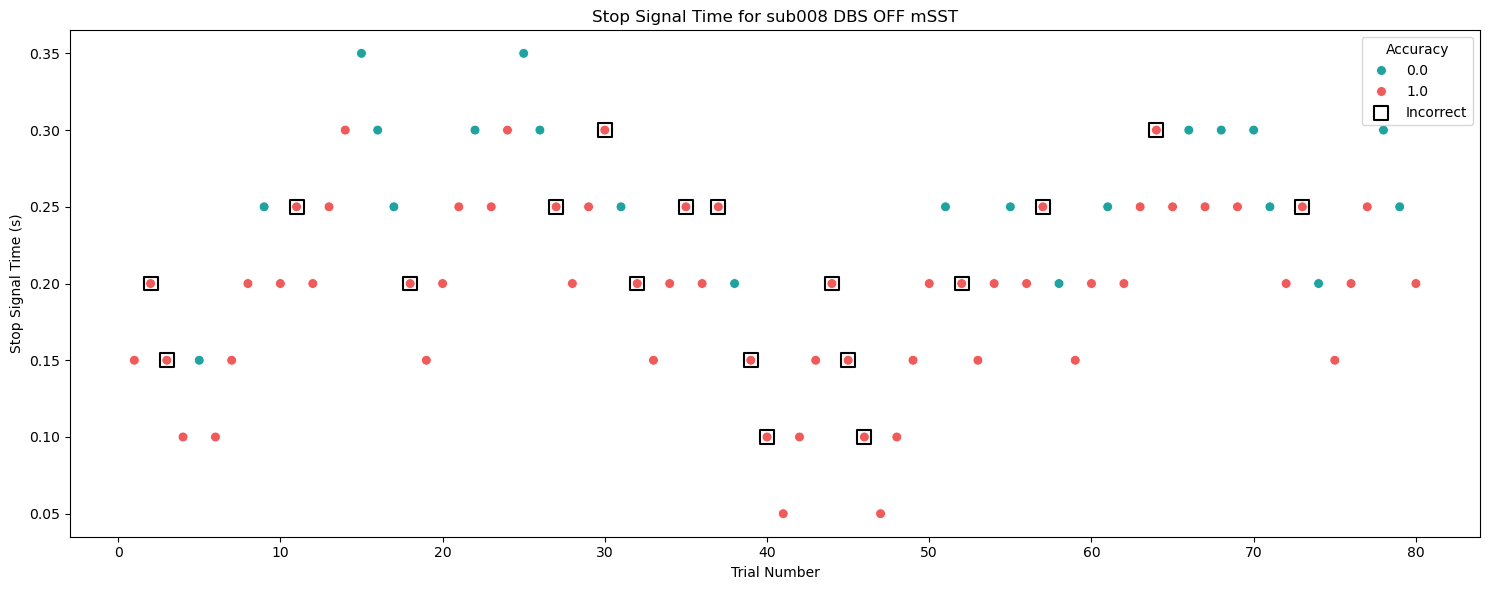

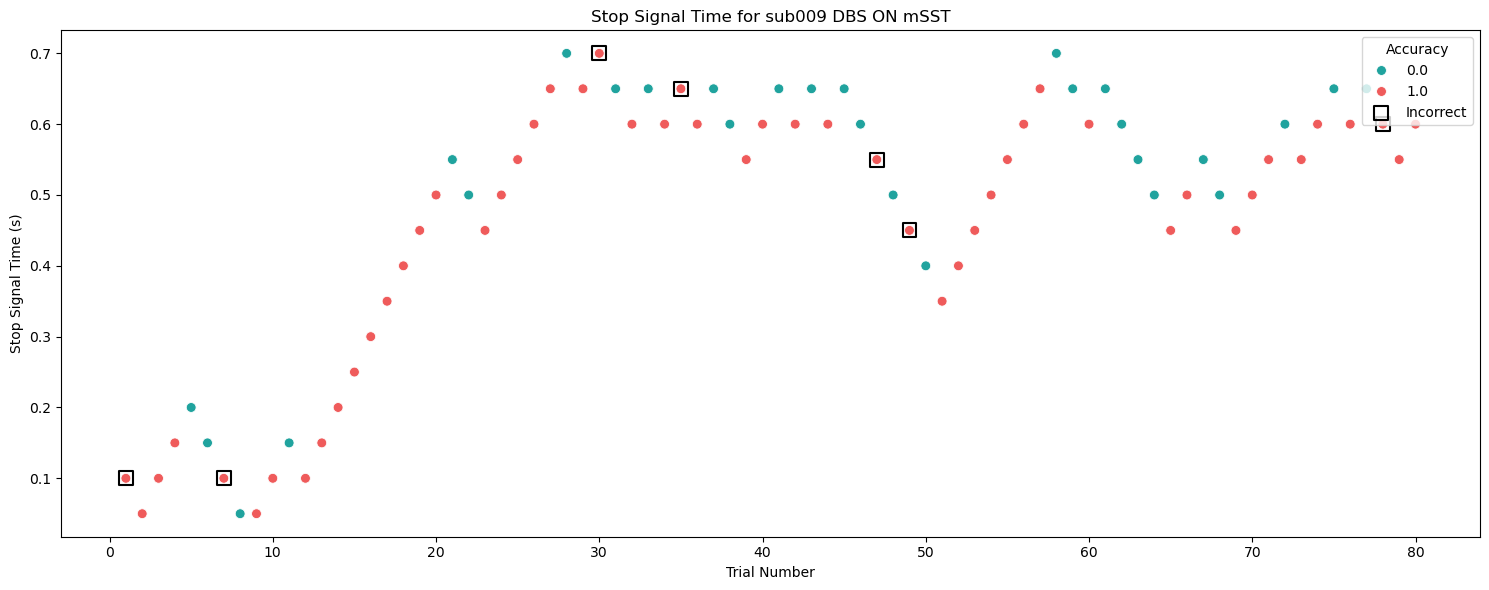

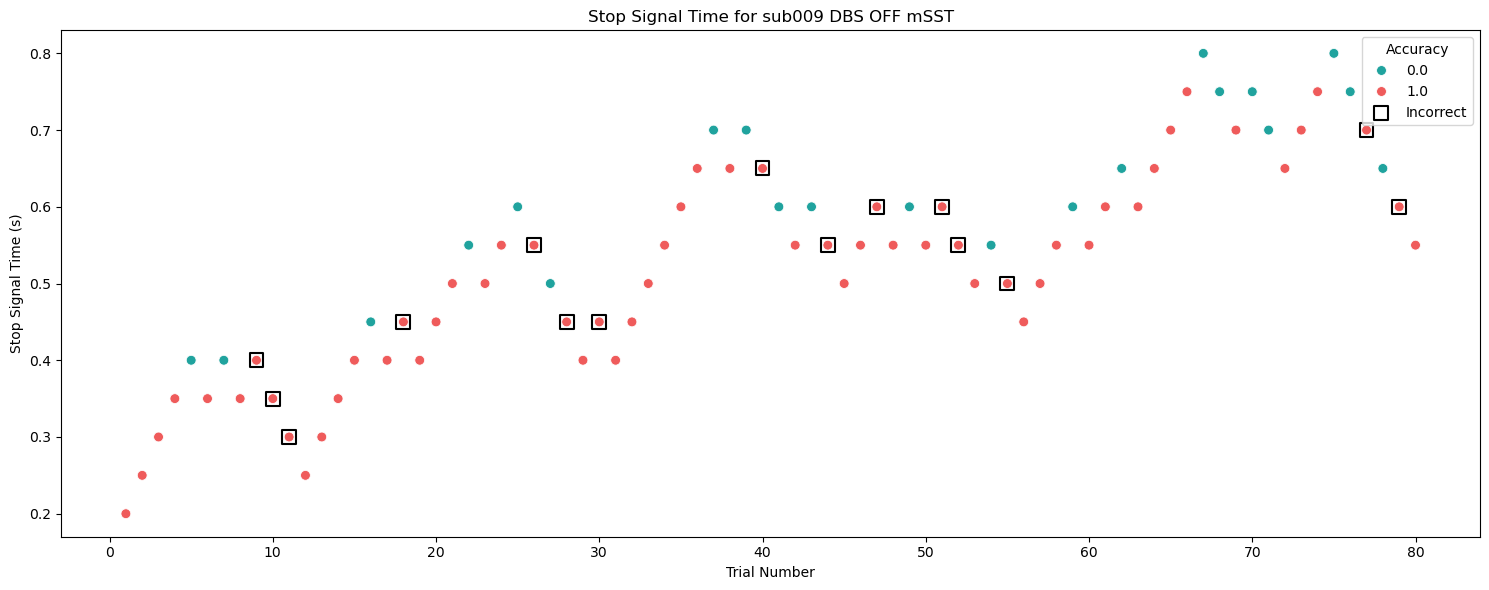

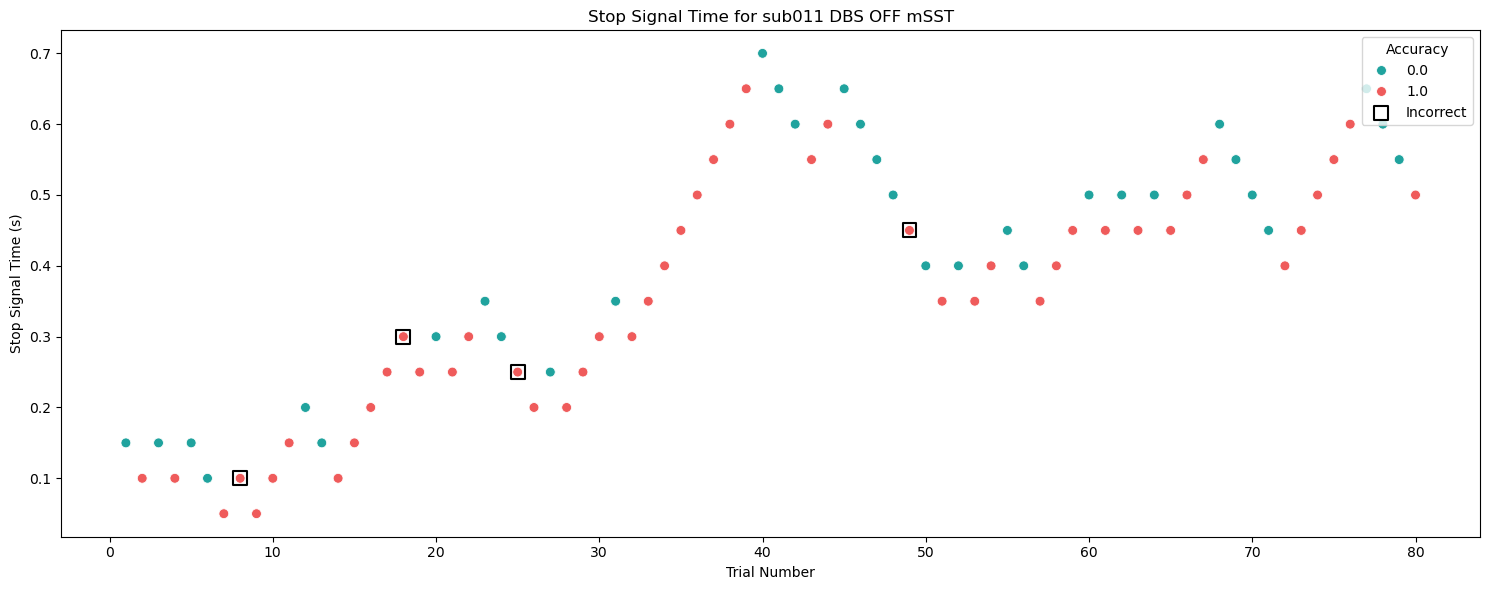

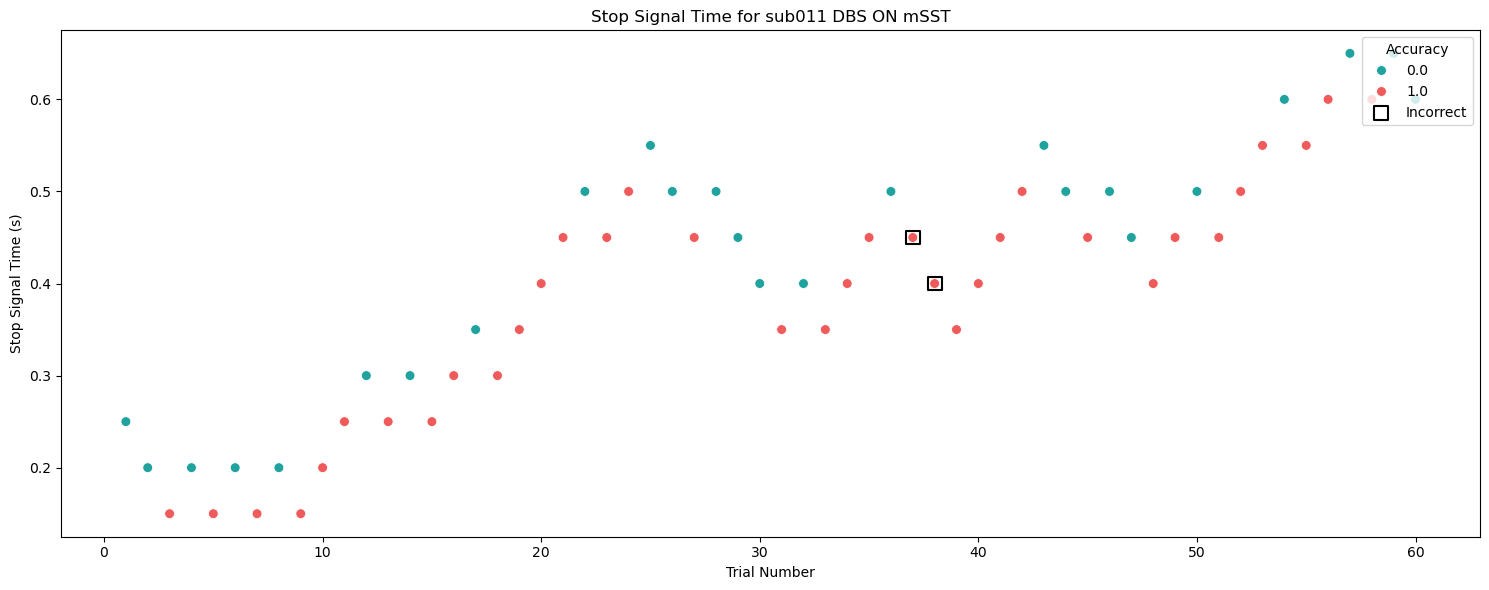

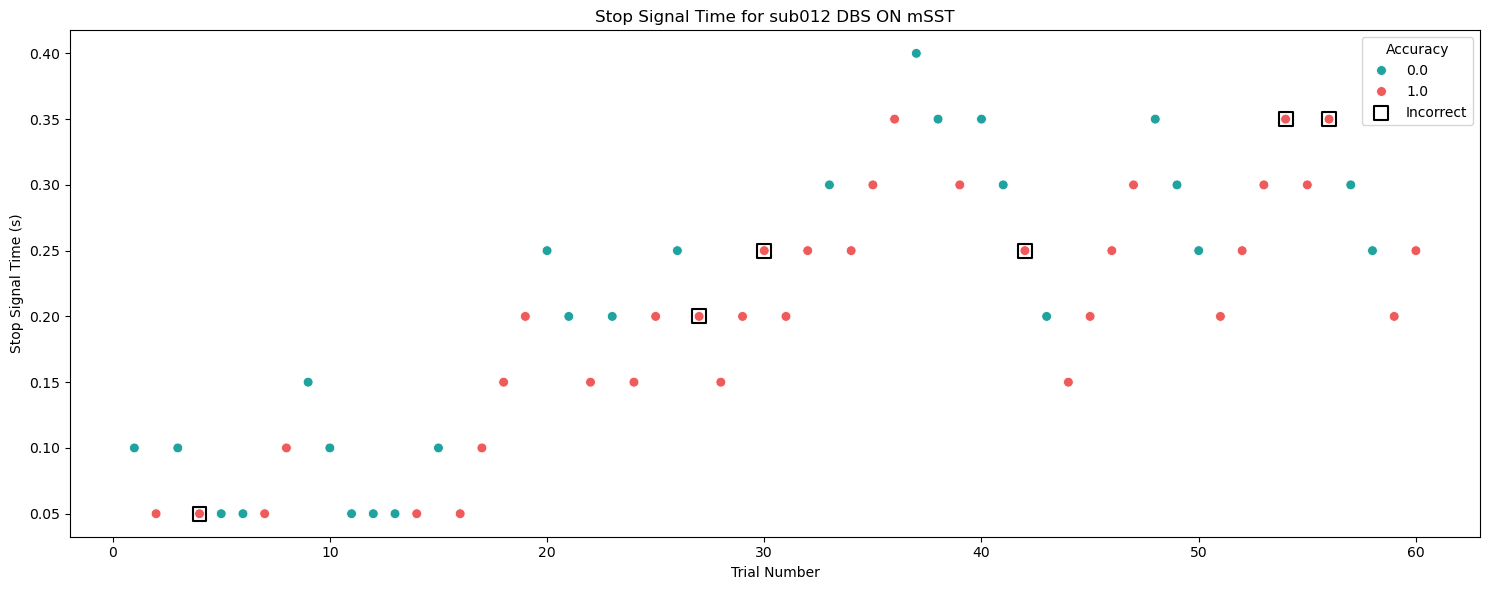

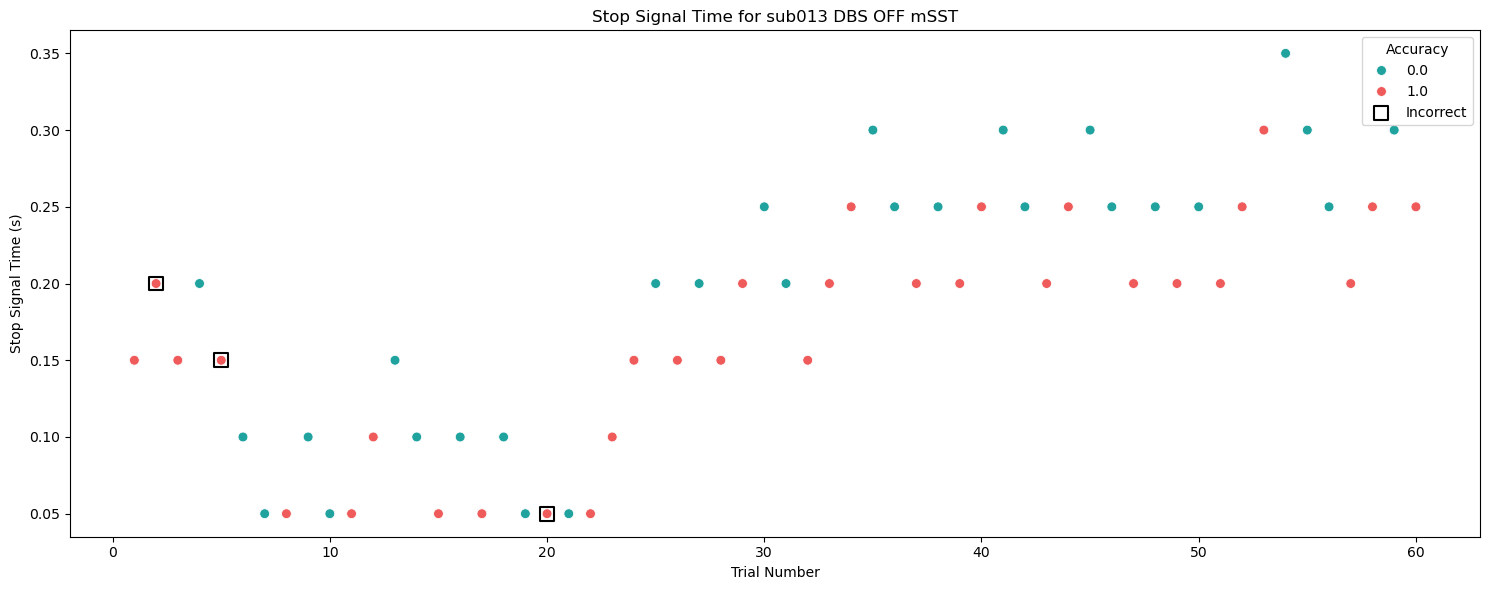

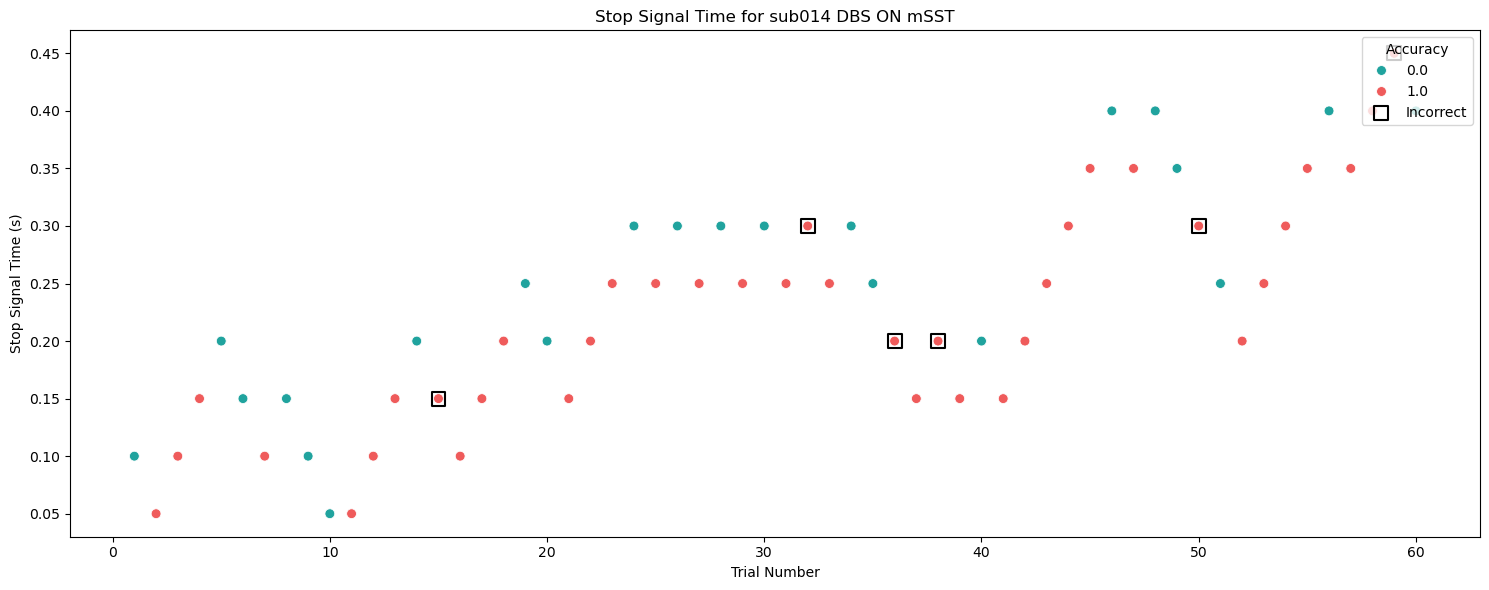

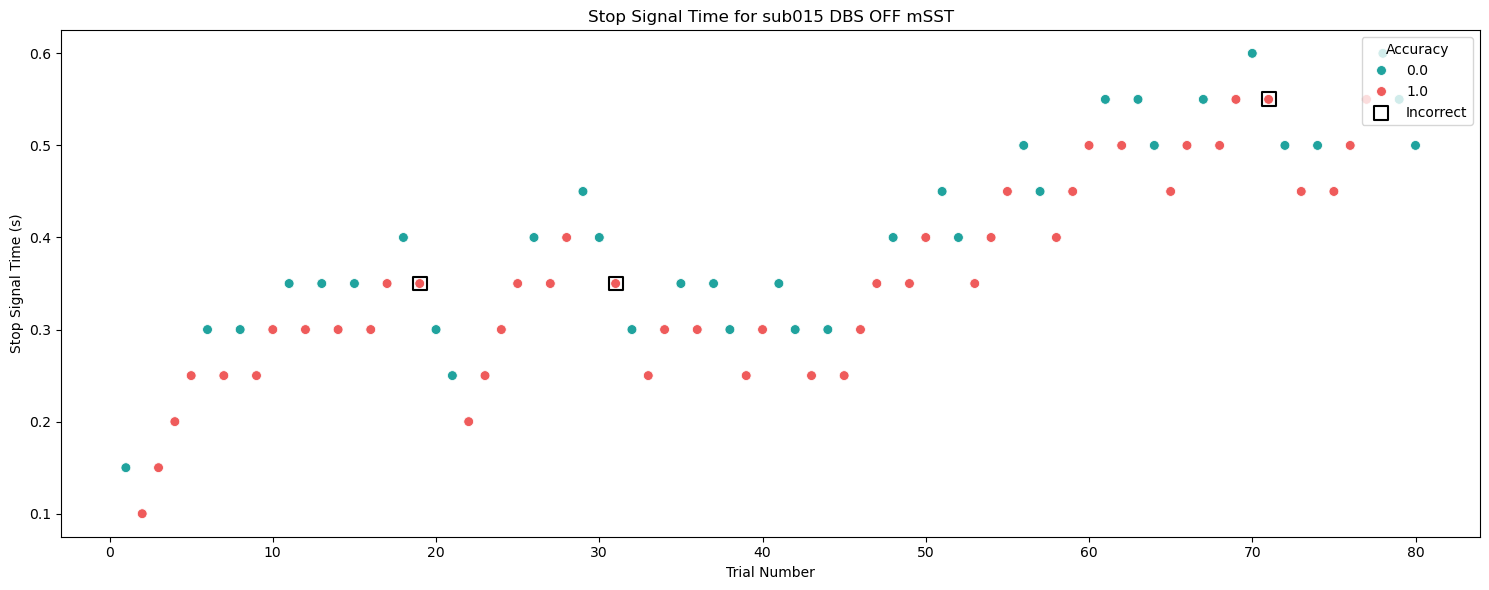

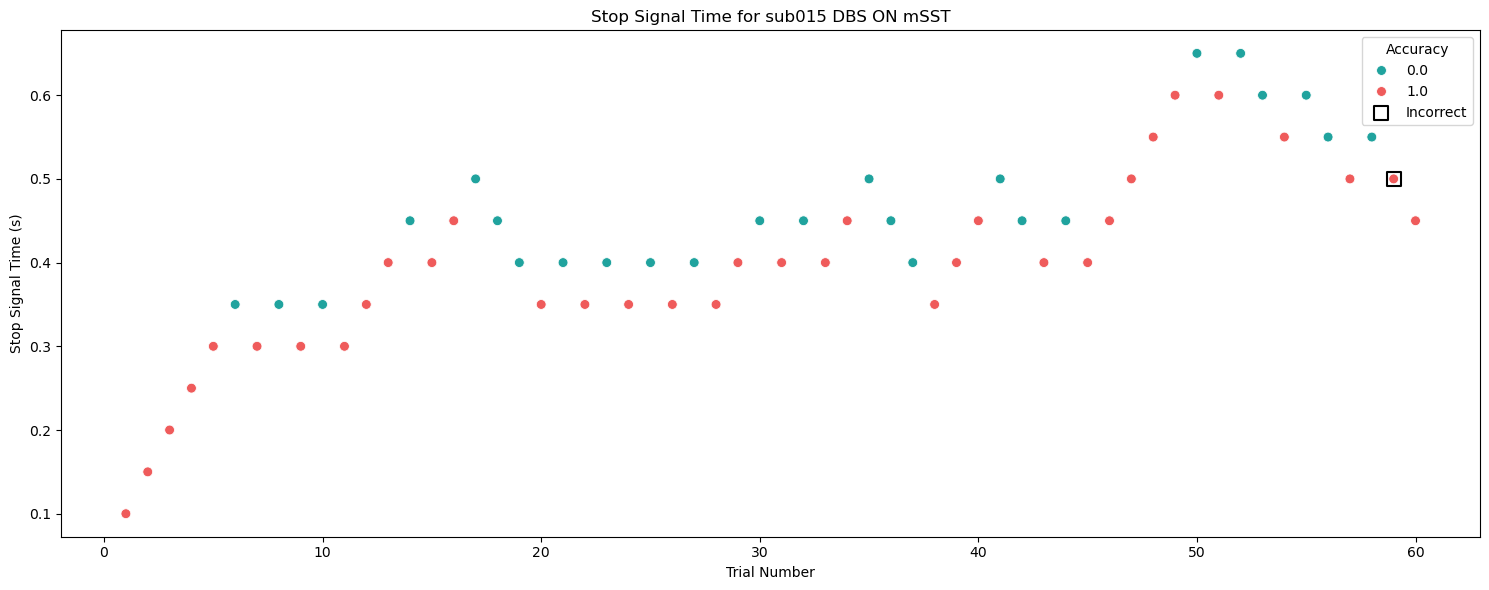

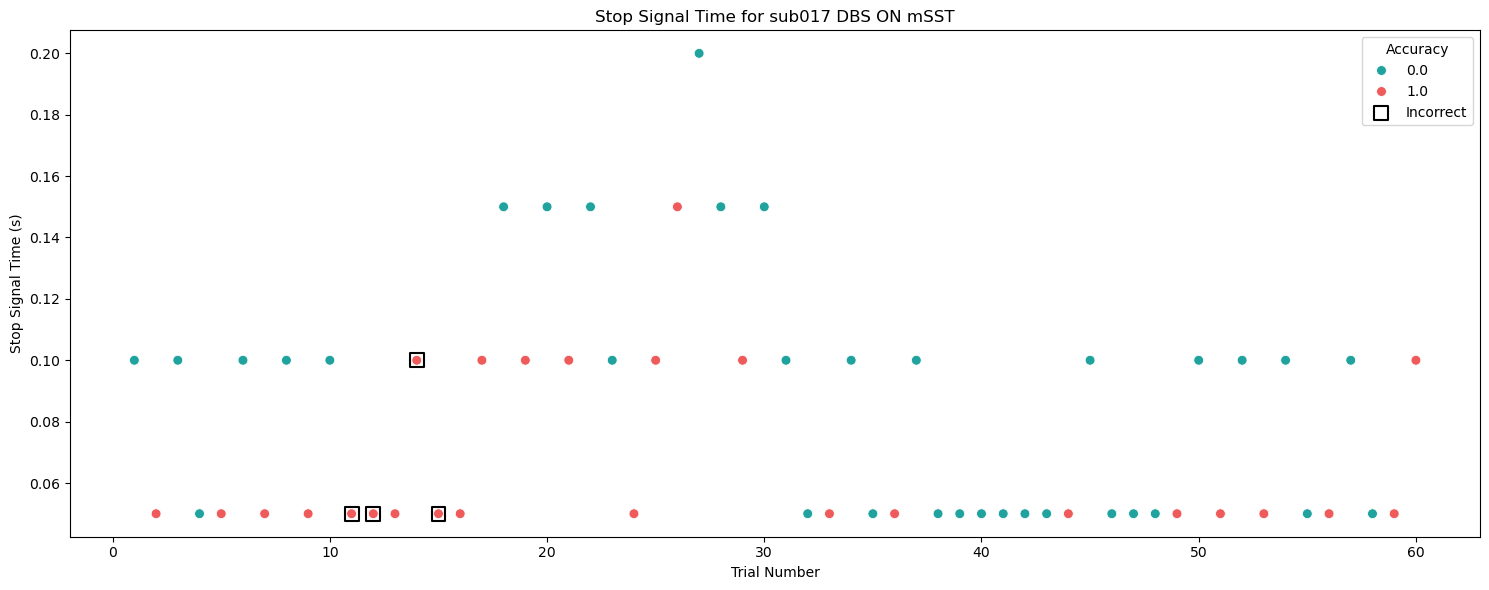

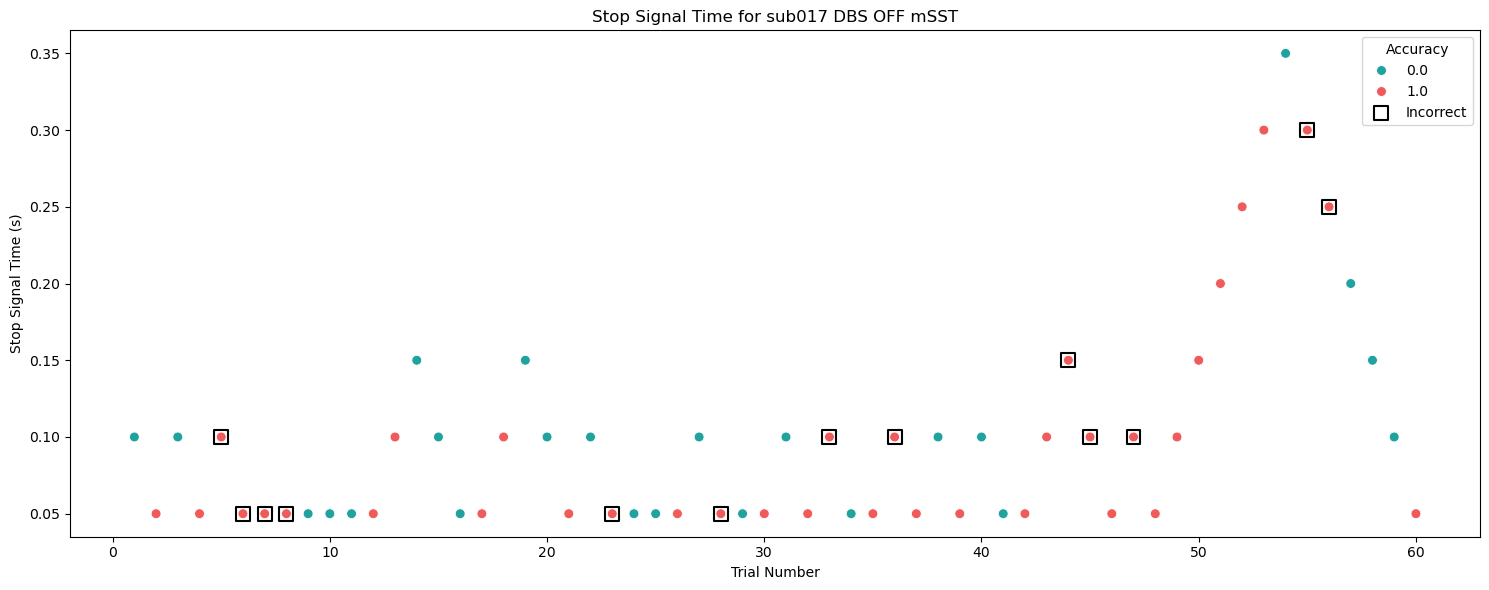

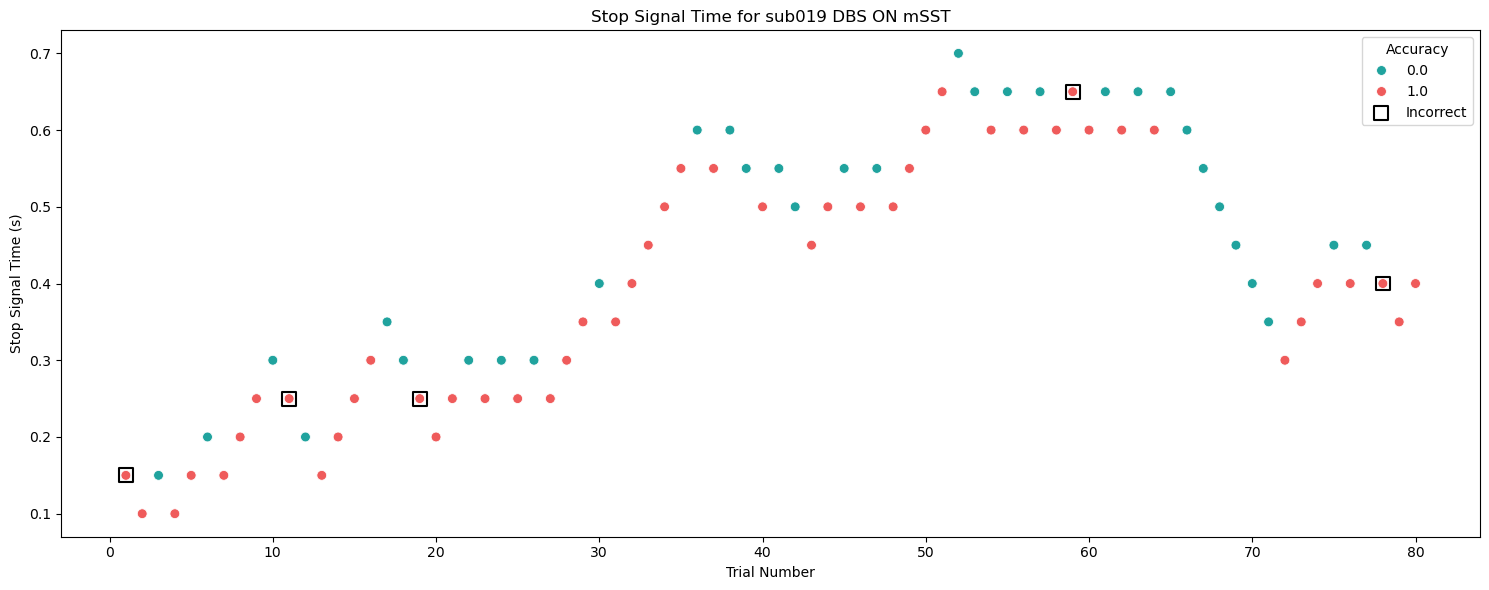

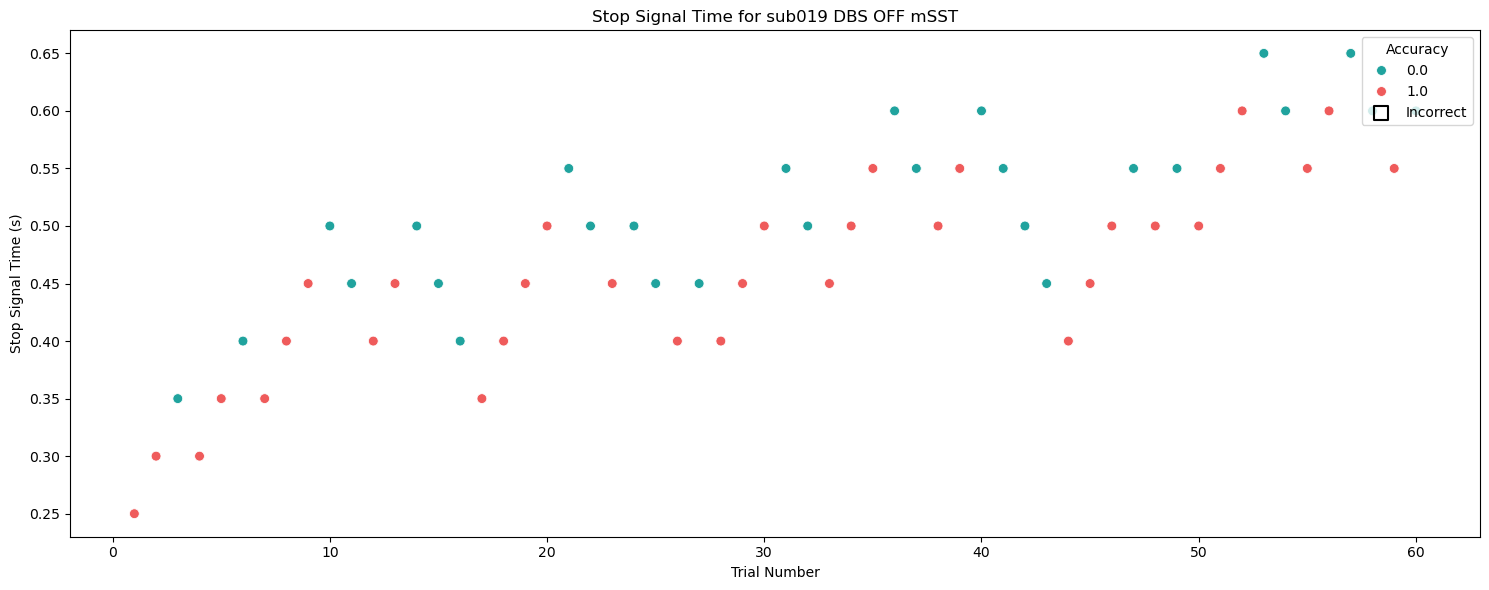

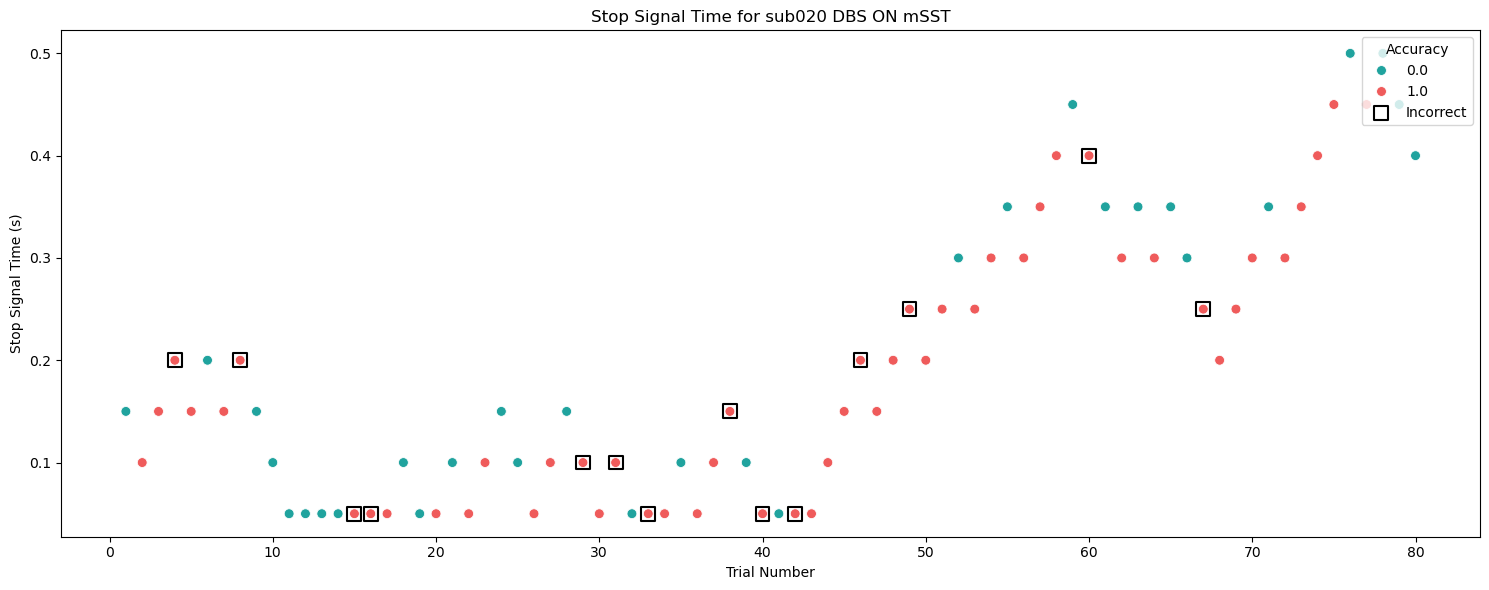

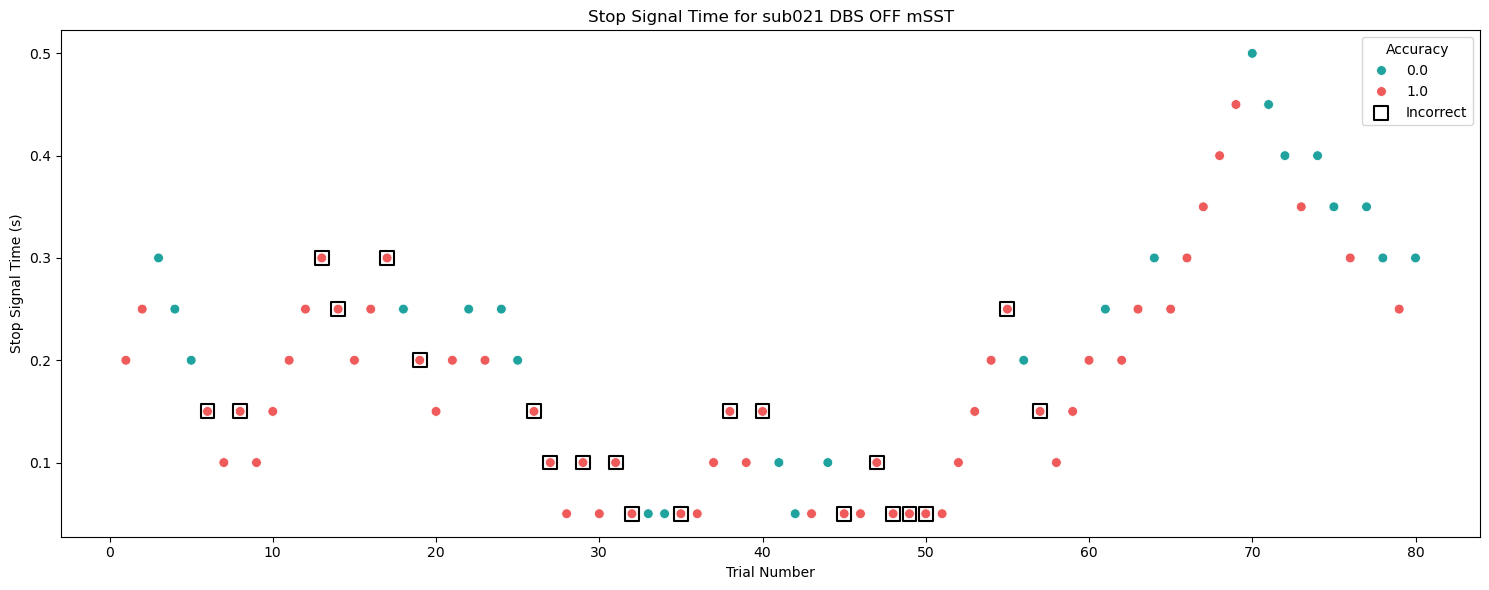

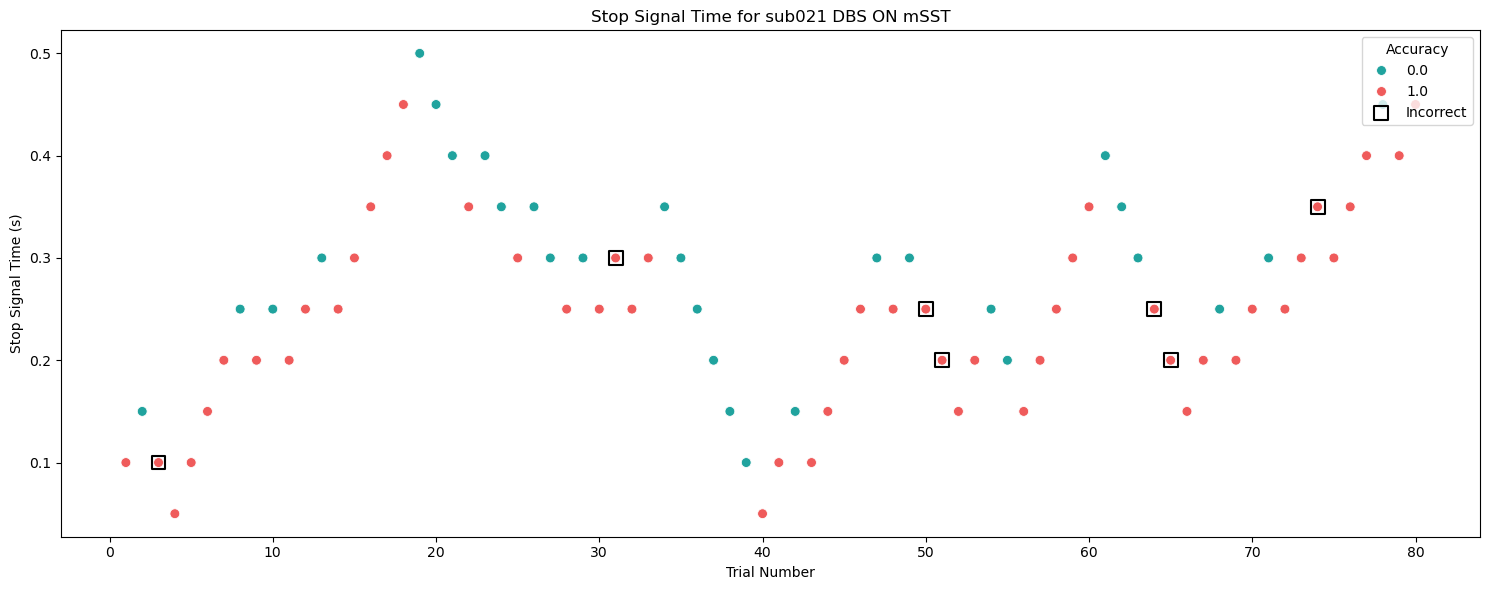

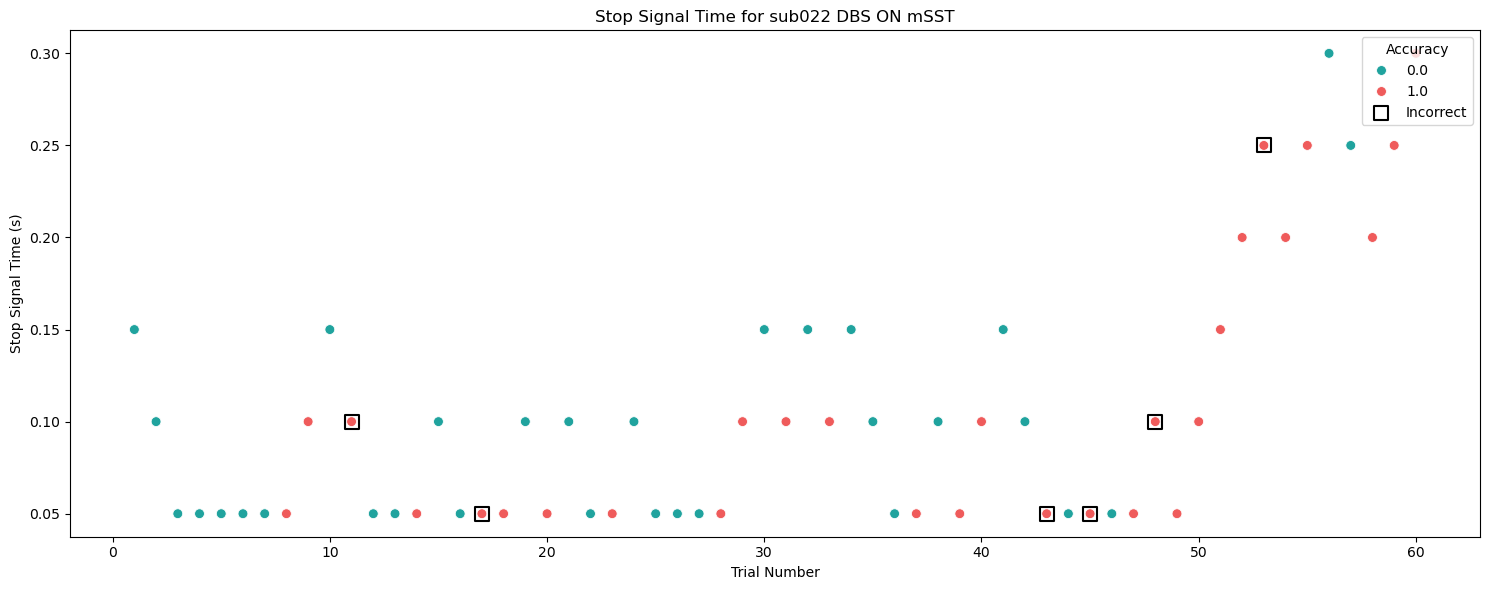

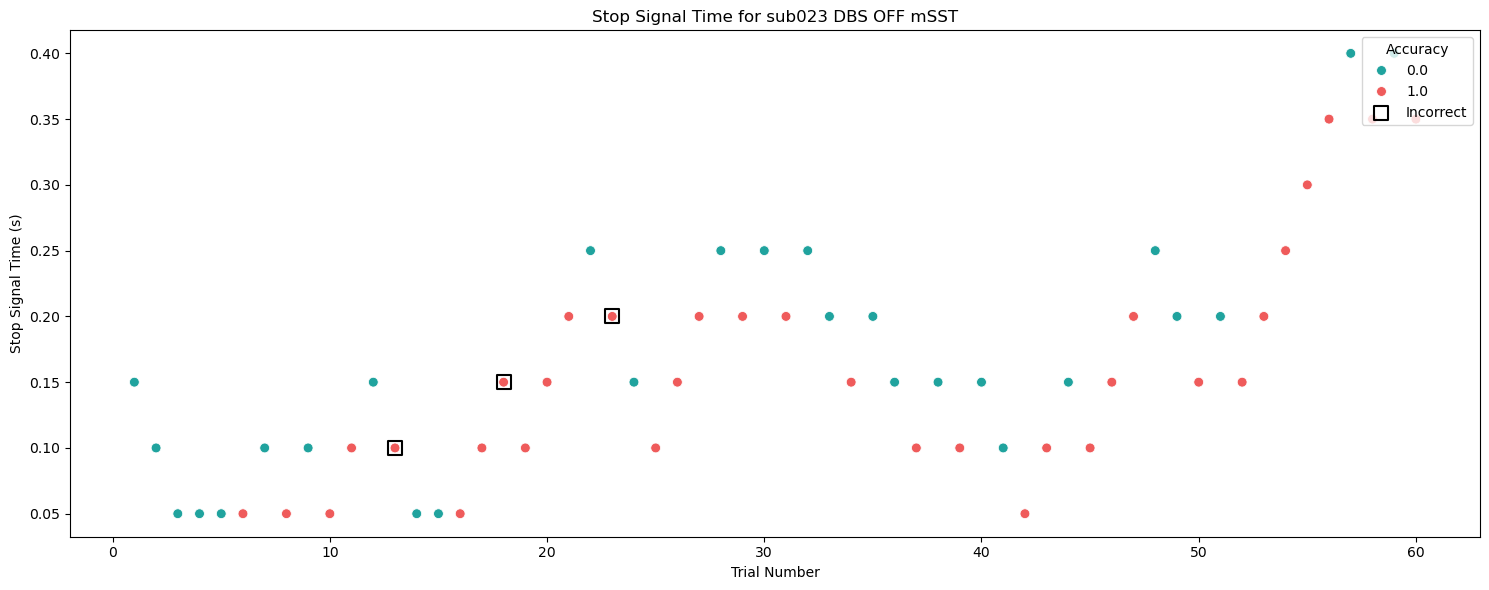

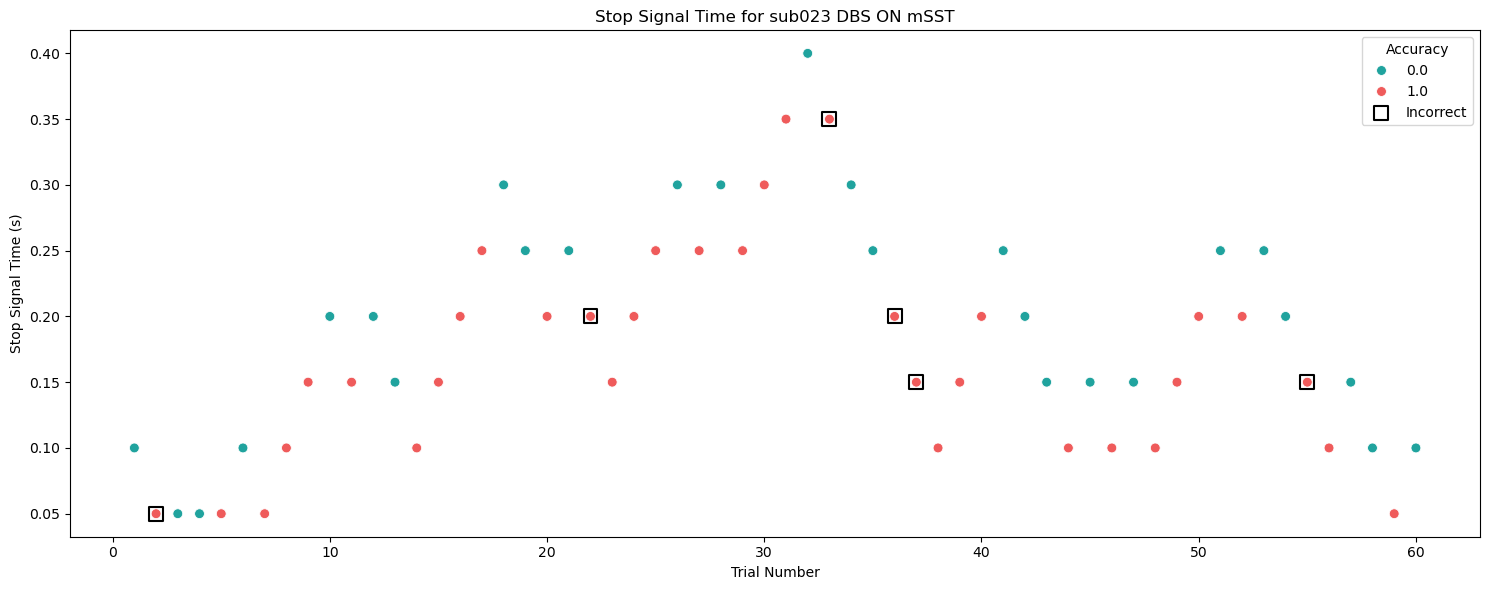

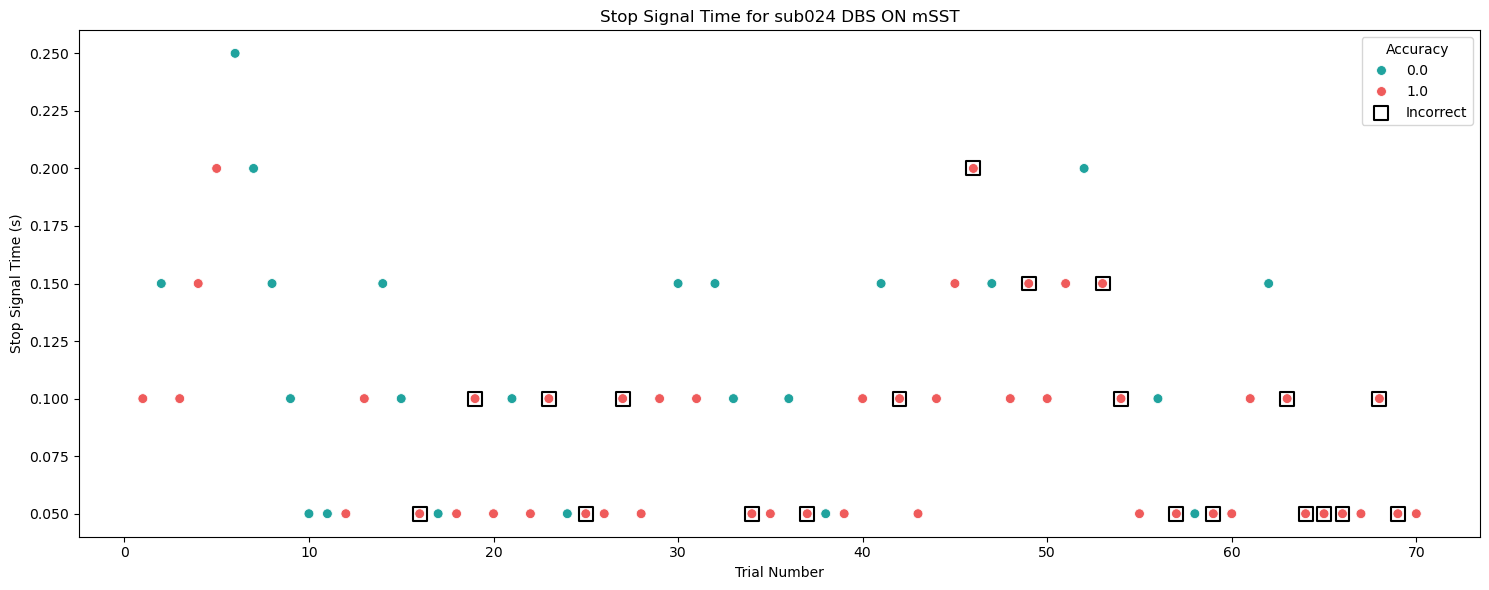

In [21]:
# create a plot for each subject representing the stop signal time in Y and the accuracy as color
for sub in staircase_df['subject'].unique():
    sub_df = staircase_df[staircase_df['subject'] == sub]

    plt.figure(figsize=(15, 6))

    # base scatterplot with color-coded accuracy
    sns.scatterplot(
        data=sub_df, x='trial_number', y='stop_signal_time',
        hue='key_resp_experiment.corr',
        palette={0: '#20a39e', 1: '#ef5b5b'}, s=50
    )

    # overlay square black markers for incorrect trials
    incorrect_df = sub_df[sub_df['correct'] == False]

    # plot results for each patient
    plt.scatter(
        incorrect_df['trial_number'],
        incorrect_df['stop_signal_time'],
        facecolors='none', edgecolors='black', marker='s', s=100, linewidths=1.5, label='Incorrect'
    )

    plt.title(f'Stop Signal Time for {sub}')
    plt.xlabel('Trial Number')
    plt.ylabel('Stop Signal Time (s)')
    plt.legend(title='Accuracy', loc='upper right')
    plt.tight_layout()